In [1]:
#meta 1/17/2020 Kaggle Cassava Module 1-Model
#fast.ai 2020 study group Kaggle Competition
#src https://www.kaggle.com/c/cassava-leaf-disease-classification
#prev competition src https://www.kaggle.com/c/cassava-disease
#references https://arxiv.org/pdf/1908.02900.pdf

#input: exported data files from my-cassava-data
#output: model artifacts, no submission.csv
#pwd: /kaggle/working
#based on previoius version of my-kaggle-cassava-1-model.ipynb -> separate modules 1&2

#history
#12/12/2020 MY INITIAL CODE - SMALL SAMPLE
#      My sumbissions didn't work
#12/28/2020 MY MODEL TO SUBMIT
#      1st successful submit with .779 accuracy
#01/03/2021-1/16/2020 my-kaggle-cassava-1-model_score0877a.ipynb
#      1-MODEL - MODEL v2 FULL W/ INFERENCE + EXPORT
#      in FULL mode, train entire ds, export model
#      delta dataprep: splitter=ColSplitter(), item_tfms = None, batch_tfms = [ *aug_transforms(flip_vert=True, max_zoom=3.0), Normalize.from_stats(*imagenet_stats)])
#                      bs=32
#      model: learn = cnn_learner(dls, resnet18, loss_func=LabelSmoothingCrossEntropy(), metrics=accuracy)
#      learn.fine_tune(15)
#      Score: 0.877  GPU submission time: ~2hrs Rank: 1434
#      Note: Same model v2 submitted with TTA scored only .889 GPU submission time: 15min Rank: 1434

#here 1/17/2020 MODULE 1-MODEL (GPU) v4 FULL DS OS (OVERSAMPLE) W/ INFERENCE + EXPORT
#      $params: DEBUG = 0, DS_OVERSAMPLED = 1
#      in FULL mode, train entire ds oversampled (exported from Module 0), export model
#      dataprep: splitter=ColSplitter(), item_tfms = None, batch_tfms = [ *aug_transforms(flip_vert=True, max_zoom=3.0), Normalize.from_stats(*imagenet_stats)])
#                bs=32
#      model: learn = cnn_learner(dls, resnet18, loss_func=LabelSmoothingCrossEntropy(), metrics=accuracy)
#      learn.fine_tune(15)
#      preds,_ = learn.get_preds(dl=test_dl), no TTA
#      Score: .876  GPU submission time: ~3hrs Rank: none
#here 1/17/2020 MODULE 1-MODEL (GPU) v4 FULL DS OS (OVERSAMPLE) W/ INFERENCE + EXPORT
#      Same as above, try fine_tune(20)


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import os
import time #to track performance time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#stratified split
from sklearn.model_selection import StratifiedShuffleSplit

#modeling
from fastai.vision.all import *


# Input data files are available in the read-only "../input/" directory
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
#--constants and variables
SEED = 24 
DEBUG = 0 #$params
DS_OVERSAMPLED = 1 #$params

#set paths
path = Path('../input/cassava-leaf-disease-classification')
path_data = Path('../input/my-cassava-data')

#--functions
def get_x(row): return path/'train_images'/row['image_id']
def get_y(row): return row['label']

#--functions
#define label lookup 
def lookup_label(image_id): return int(df_train[df_train['image_id']== image_id]['label'])
def lookup_label(image_id): return int(df_train[df_train['image_id']== image_id]['label'][0])
#test function
#lookup_label('100042118.jpg')

# Cassava Disease Classification
##### Objective: Classify pictures of cassava leaves into 1 of 4 disease categories or healthy.

As the second-largest provider of carbohydrates in Africa, cassava is a key food security crop grown by smallholder farmers because it can withstand harsh conditions. At least 80% of household farms in Sub-Saharan Africa grow this starchy root, but viral diseases are major sources of poor yields. With the help of data science, it may be possible to identify common diseases so they can be treated.

Existing methods of disease detection require farmers to solicit the help of government-funded agricultural experts to visually inspect and diagnose the plants. This suffers from being labor-intensive, low-supply and costly. As an added challenge, effective solutions for farmers must perform well under significant constraints, since African farmers may only have access to mobile-quality cameras with low-bandwidth.

In this competition, we introduce a dataset of 21,367 labeled images collected during a regular survey in Uganda. Most images were crowdsourced from farmers taking photos of their gardens, and annotated by experts at the National Crops Resources Research Institute (NaCRRI) in collaboration with the AI lab at Makerere University, Kampala. This is in a format that most realistically represents what farmers would need to diagnose in real life.

Your task is to classify each cassava image into four disease categories or a fifth category indicating a healthy leaf. With your help, farmers may be able to quickly identify diseased plants, potentially saving their crops before they inflict irreparable damage.


## 0. Load Data


### 0.1 Images  
21397 train images and 1 test image

In [4]:
(path/'train_images').ls(), (path/'test_images').ls()

((#21397) [Path('../input/cassava-leaf-disease-classification/train_images/1235188286.jpg'),Path('../input/cassava-leaf-disease-classification/train_images/1215607589.jpg'),Path('../input/cassava-leaf-disease-classification/train_images/478554372.jpg'),Path('../input/cassava-leaf-disease-classification/train_images/2763304605.jpg'),Path('../input/cassava-leaf-disease-classification/train_images/2826122413.jpg'),Path('../input/cassava-leaf-disease-classification/train_images/111117998.jpg'),Path('../input/cassava-leaf-disease-classification/train_images/231268038.jpg'),Path('../input/cassava-leaf-disease-classification/train_images/4201965605.jpg'),Path('../input/cassava-leaf-disease-classification/train_images/3224710052.jpg'),Path('../input/cassava-leaf-disease-classification/train_images/1290729293.jpg')...],
 (#1) [Path('../input/cassava-leaf-disease-classification/test_images/2216849948.jpg')])

In [5]:
#load train/test images
train_img = get_image_files(path/'train_images')
test_img = get_image_files(path/'test_images')

print("Number of files: ", (len(train_img), len(test_img)))

Number of files:  (21397, 1)


### 0.2 Disease Labels Mapping

In [6]:
with open((path/'label_num_to_disease_map.json')) as json_file:
    target_map = json.load(json_file)
    
print(target_map)

{'0': 'Cassava Bacterial Blight (CBB)', '1': 'Cassava Brown Streak Disease (CBSD)', '2': 'Cassava Green Mottle (CGM)', '3': 'Cassava Mosaic Disease (CMD)', '4': 'Healthy'}


### 0.3 Train Dataset
Export from module 0-Data

In [7]:
#$param
if DEBUG:
    if DS_OVERSAMPLED:
        df_train = torch.load(path_data/'df_train_os_mini.pkl')
    else:
        df_train = torch.load(path_data/'df_train_mini.pkl')
else:
    if DS_OVERSAMPLED:
        df_train = torch.load(path_data/'df_train_os.pkl')
    else:
        df_train = torch.load(path_data/'df_train.pkl')
        
print('train data\n', df_train.shape)
display(df_train.head(6))

train data
 (27988, 4)


,index,image_id,label,is_valid
0,0,1000015157.jpg,0,0
1,1,1000201771.jpg,3,0
2,2,100042118.jpg,1,0
3,3,1000723321.jpg,1,0
4,4,1000812911.jpg,3,0
5,5,1000837476.jpg,3,1


0     1957
1     3940
2     4295
3    13158
4     4638
Name: label, dtype: int64


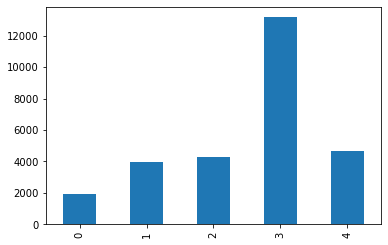

In [8]:
print(df_train['label'].value_counts().sort_index())
df_train['label'].value_counts().sort_index().plot(kind='bar');

In [9]:
#view an image
image_example = '100042118.jpg' 
#print(lookup_label(image_example)) #$ac
print(path/'train_images'/image_example)
#Image.open(path/'train_images'/image_example)


../input/cassava-leaf-disease-classification/train_images/100042118.jpg



### 1.1 From Data to Dataloaders
with DataBlock

path = Path('../input/cassava-leaf-disease-classification')

In [10]:
def get_x(row): return path/'train_images'/row['image_id']
def get_y(row): return row['label']

In [11]:
#dataloaders
dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_x = get_x,
                 get_y = get_y,
                 splitter=ColSplitter(), 
                 item_tfms = None, 
                 batch_tfms = [ *aug_transforms(flip_vert=True, max_zoom=3.0), Normalize.from_stats(*imagenet_stats)])
#                      

dls = dblock.dataloaders(df_train, bs=32)

len(dls.train_ds), len(dls.valid_ds)

(23708, 4280)

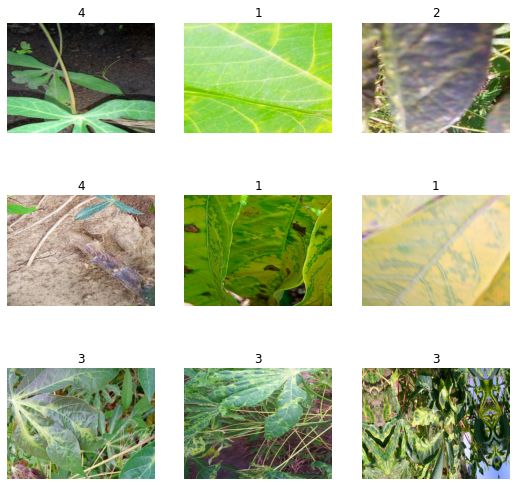

In [12]:
dls.train.show_batch()

## 2. Model
Learn a model to classify a given image into these 4 disease categories or a 5th category indicating a healthy leaf, using the images in the training data

### 2.0 Pretrained model offline

In [13]:
#src Daniel
if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
        os.makedirs('/root/.cache/torch/hub/checkpoints/')
!cp '../input/resnet185c106cdepth/resnet18-5c106cde.pth' '/root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth'

In [14]:
#if Internet enabled, download the pretrained model
#import torchvision.models as models
##arch = models.resnet18

#if Internet not enabled
#RESNET18_PATH = '/kaggle/input/resnet185c106cdepth/resnet18-5c106cde.pth'
#torch.load(resnet18, RESNET18_PATH)

### 2.1 Train 
Fine-tune n epochs

In [15]:
#track time
t0 = time.time()

#Ch7 pg251 LabelSmoothingCrossEntropy()
learn = cnn_learner(dls, resnet18, loss_func=LabelSmoothingCrossEntropy(), metrics=accuracy)
if DEBUG:
    learn.fine_tune(2)
else:
    learn.fine_tune(20) #$param

t1 = time.time()
print ("Training time (in min)", (time.time() - t0)/60)

epoch,train_loss,valid_loss,accuracy,time
0,1.171971,0.967801,0.717290,07:58


epoch,train_loss,valid_loss,accuracy,time
0,0.936020,0.768368,0.820561,07:55
1,0.861939,0.722253,0.847196,07:55
2,0.829866,0.703955,0.855140,07:55
3,0.827900,0.683666,0.864720,07:55
4,0.839908,0.709216,0.848832,07:54
5,0.792082,0.695955,0.855607,07:55
6,0.803461,0.687300,0.858878,07:55
7,0.785359,0.674616,0.866355,07:54
8,0.766068,0.679500,0.867757,07:54
9,0.751069,0.683589,0.863551,07:56


Training time (in min) 166.57939622799555


In [16]:
#save the state of your model
if DEBUG:
    learn.save('my-mini-2epochs')
else:
    learn.save('my-full-15epochs') #$param
    
#export model
learn.export()

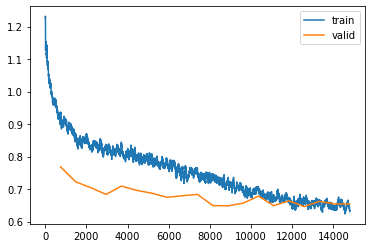

In [17]:
learn.recorder.plot_loss()

### 2.2 Evaluate

In [18]:
#learn = load_learner('../input/mycassavamodelv0/export.pkl')

In [19]:
#interp = ClassificationInterpretation.from_learner(learn)
#interp.plot_confusion_matrix()

In [20]:
#interp.most_confused(min_val=10)

In [21]:
#use exports for inference
#mystop #$param

## 3. Predict
Predict on one file

In [22]:
#view test images - only one
#Image.open(test_img[0])

#predict one, returns a tuple, get 0th item
y_hat = learn.predict(test_img[0])
y_hat[0]

'4'

Test dataset

In [23]:
#template
sample_submission = pd.read_csv(path/'sample_submission.csv')
submission = sample_submission.copy()

#create test images id
test_img_id = [os.path.join(path/'test_images', x) for x in submission['image_id'].values]

#images in test files
test_img_id

['../input/cassava-leaf-disease-classification/test_images/2216849948.jpg']

In [24]:
test_dl = dls.test_dl(test_img_id)
len(test_dl)

#predict, no TTA
preds,_ = learn.get_preds(dl=test_dl)
#preds

#submission
submission['label'] = preds.argmax(dim=-1).numpy()
submission.head()

,image_id,label
0,2216849948.jpg,4


## 4. Submit


In [25]:
submission.to_csv('submission.csv', index=False)
